# USING LSTM TO PREDICT GDP PER CAPITA IN SUB-SAHARAN AFRICA

In [ ]:
#Import libraries
import pandas as pd
import numpy as np
import torch.optim as optim #The neural network optimizer
from sklearn.model_selection import train_test_split #Splitting and normalization
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#To define and inspect the kNN model
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from math import sqrt
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, Embedding 
from keras import backend as K
#Visualization libraries
from matplotlib import pyplot
import seaborn as sns 
import matplotlib.pyplot as plt 

In [ ]:
#Upload file from local directory
#For images you can upload a zip file
from google.colab import files
uploaded = files.upload()

Saving Theses complete data.csv to Theses complete data.csv


In [ ]:
df = pd.read_csv("Theses complete data.csv")
data = df.values
df.head()

,YEAR,GDP per capita (current US$),"Electricity production from renewable sources, excluding hydroelectric (kWh)",Access to electricity (% of population),Total greenhouse gas emissions (kt of CO2 equivalent),"Population, total",Current health expenditure per capita (current US$),"Government expenditure on education, total (% of GDP)","Inflation, consumer prices (annual %)","Employment to population ratio, 15+, total (%) (modeled ILO estimate)"
0,1971,451.694009,163000000.0,NaN,NaN,298284475,NaN,NaN,NaN,NaN
1,1972,497.240127,165000000.0,NaN,NaN,306359650,NaN,NaN,NaN,NaN
2,1973,617.167676,170000000.0,NaN,NaN,314761504,NaN,NaN,NaN,NaN
3,1974,784.227147,175000000.0,NaN,NaN,323500333,NaN,NaN,19.598394,NaN
4,1975,844.409778,172000000.0,NaN,NaN,332583481,NaN,NaN,15.224099,NaN


# (A) DATA WRANGLING
DATA CLEANING BY REPLACING BY MULTIVARIATE FEATURE IMPUTATION

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 10 columns):
 #   Column                                                                        Non-Null Count  Dtype  
---  ------                                                                        --------------  -----  
 0   YEAR                                                                          51 non-null     int64  
 1   GDP per capita (current US$)                                                  51 non-null     float64
 2   Electricity production from renewable sources, excluding hydroelectric (kWh)  45 non-null     float64
 3   Access to electricity (% of population)                                       28 non-null     float64
 4   Total greenhouse gas emissions (kt of CO2 equivalent)                         30 non-null     float64
 5   Population, total                                                             51 non-null     int64  
 6   Current health expenditure per capit

In [ ]:
#Multivariate imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(data)

x_prep = data[:,:]
clean = np.round(imp.transform(x_prep))

In [ ]:
# Sanity check to make sure all missing values are handled
# True=there is a NaN and False=no NaN
print(np.isnan(clean))

[[False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False

# (B) EXPLORATORY DATA ANALYSIS

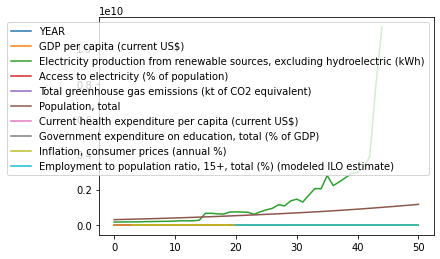

In [ ]:
# line plot
df.plot()
pyplot.show()

In [ ]:
#View the number of elements in the dataset (rows*columns)
print(clean.size)
#View the number of Dimensions(2 in this case)
print(clean.ndim)

510
2


In [ ]:
# Creating a correlation matrix for each feature 
print(np.corrcoef(clean.T))

[[ 1.          0.85369323  0.80779038  0.98515796  0.98739094  0.98629583
   0.8822963   0.81710225 -0.50981037 -0.93898139]
 [ 0.85369323  1.          0.81968978  0.87044988  0.88653718  0.88009772
   0.9948343   0.80709523 -0.44143241 -0.78539127]
 [ 0.80779038  0.81968978  1.          0.8330372   0.8499762   0.85715629
   0.82206371  0.77888742 -0.52143757 -0.83234336]
 [ 0.98515796  0.87044988  0.8330372   1.          0.99273218  0.99289776
   0.89603172  0.81309968 -0.5307342  -0.94348268]
 [ 0.98739094  0.88653718  0.8499762   0.99273218  1.          0.99806696
   0.91251021  0.83966907 -0.52585063 -0.95538458]
 [ 0.98629583  0.88009772  0.85715629  0.99289776  0.99806696  1.
   0.90323034  0.84423872 -0.53155567 -0.96449005]
 [ 0.8822963   0.9948343   0.82206371  0.89603172  0.91251021  0.90323034
   1.          0.81584879 -0.4542661  -0.80850364]
 [ 0.81710225  0.80709523  0.77888742  0.81309968  0.83966907  0.84423872
   0.81584879  1.         -0.46174632 -0.81664848]
 [-0.509

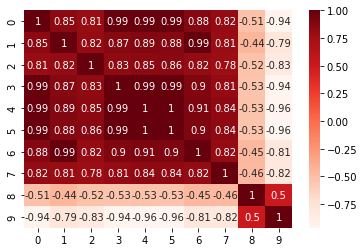

In [ ]:
#Graph of the correlation matrix
sns.heatmap(np.corrcoef(clean.T), annot=True, cmap='Reds')
plt.show()

In [ ]:
# create timeseries plot for GDP and our main dependent variable electricty production from renewable sources
import plotly.graph_objs as go
import plotly.offline as py
X=clean[:,0]
y1=clean[:,1]
y2=clean[:,2]
layout = go.Layout(title= 'Sub-Saharan African GDP per capita PPP 1960-2021 current international $',
    xaxis = dict(ticks='', nticks=43),
    yaxis = dict(nticks=20))
trace0 = go.Scatter(x=X,y=y1, mode = 'lines',name="GDP per capita (current $US)", marker = dict(size=12, color='red'))
trace1 = go.Scatter(x=X,y=y2, mode = 'lines', name="Electricity production from renewable sources, excluding hydroelectric (kWh)", marker = dict(size=12, color='darkcyan'))
data = [trace0,trace1]
fig =go.Figure(data=data, layout=layout)
py.iplot(fig, filename='heatmap',show_link=False)


# (C) FEATURE ENGINEERING

Engineered all the features here through normalization.

In [ ]:
#Turn our data back to pandas 
clean = pd.DataFrame(clean, columns = ['YEAR', 'GDP per capita (current US$)', 'Electricity production from renewable sources, excluding hydroelectric (kWh)', 'Access to electricity (% of population)',	'Total greenhouse gas emissions (kt of CO2 equivalent)',	'Population, total',	'Current health expenditure per capita (current US$)',	'Government expenditure on education, total (% of GDP)',	'Inflation, consumer prices (annual %)',	'Employment to population ratio, 15+, total (%) (modeled ILO estimate)'])

# (D) MODELLING

In [ ]:
df_date = clean['YEAR']
train_data, test_data = clean.iloc[0:, 1:2], clean.iloc[0:, 1:2]
test_data.reset_index(inplace=True)

In [ ]:
test_data.shape

(51, 2)

In [ ]:
test_data.drop('index', axis=1, inplace=True)
test_data.head()
#print(test_data.shape)

,GDP per capita (current US$)
0,452.0
1,497.0
2,617.0
3,784.0
4,844.0


In [ ]:
scaler_in = MinMaxScaler()  
train_scaled = scaler_in.fit_transform(train_data)

print(train_scaled.shape)

(51, 1)


In [ ]:
scaler_out = MinMaxScaler()  
train_scaled_out = scaler_out.fit_transform(train_data[['GDP per capita (current US$)']])

print(train_scaled_out.shape)

(51, 1)


In [ ]:
timesteps = 1
X_train = []
y_train = []
for i in range(1, 51):
    X_train.append(train_scaled[i-1:i]) 
    y_train.append(train_scaled[i][0]) 
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(50, 1, 1)
(50,)


In [ ]:
X_train_shape = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],  X_train.shape[2]))
X_train_shape.shape

(50, 1, 1)

In [ ]:
model = Sequential()

# Adding the first LSTM layer 
# Here return_sequences=True means whether to return the last output in the output sequence, or the full sequence.
# it basically tells us that there is another(or more) LSTM layer ahead in the network.

model.add(LSTM(units = 100, return_sequences = True, input_shape = (1, 1)))
# Dropout regularisation for tackling overfitting
model.add(Dropout(0.4))

model.add(LSTM(units = 150, return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 200, return_sequences = True))
model.add(Dropout(0.6))

model.add(LSTM(units = 200, return_sequences = True))
model.add(Dropout(0.6))

model.add(LSTM(units = 100, return_sequences = False))
model.add(Dropout(0.4))

# Adding the output layer
model.add(Dense(units = 1, activation='ReLU')) 
#ReLU helps more with the gradient descent problem than sigmoid and tanh

# Compiling the RNN
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 1)

Epoch 1/100
50/50 [==============================] - 6s 6ms/step - loss: 0.1919 - accuracy: 0.0000e+00
Epoch 2/100
50/50 [==============================] - 0s 6ms/step - loss: 0.0711 - accuracy: 0.0000e+00
Epoch 3/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0581 - accuracy: 0.0200
Epoch 4/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0248 - accuracy: 0.0200
Epoch 5/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0271 - accuracy: 0.0200
Epoch 6/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0172 - accuracy: 0.0200
Epoch 7/100
50/50 [==============================] - 0s 6ms/step - loss: 0.0304 - accuracy: 0.0200
Epoch 8/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0146 - accuracy: 0.0200
Epoch 9/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0144 - accuracy: 0.0200
Epoch 10/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0151 - accuracy: 0.0200
E

In [1]:
#ts = 9, acc:0.0188 5layers
#ts = 10, acc:0.073 4layers
#ts = 10, acc:0.02 6layers
#ts = 1, acc:0.0062 5layers

In [ ]:
# Preparation of test dataset#
#train_last_2ts = train_data.iloc[-1:]
#test_full = test_data
#test_inputs = pd.concat((train_last_2ts, test_full), axis = 0)

test_inputs = test_data
print(test_inputs.shape)
test_inputs.head()

(51, 1)


,GDP per capita (current US$)
0,452.0
1,497.0
2,617.0
3,784.0
4,844.0


In [ ]:
test_inputs_scaled = scaler_in.transform(test_inputs)
test_inputs_scaled.shape

(51, 1)

In [ ]:
# same steps as we followed while processing training data
X_test = []
for i in range(1, 51):
    X_test.append(test_inputs_scaled[i-1:i])
X_test = np.array(X_test)
print(X_test.shape)


(50, 1, 1)


In [ ]:
len(X_test)

50

In [ ]:
predictions = model.predict(X_test)

2/2 [==============================] - 3s 8ms/step


In [ ]:
# inverse_transform because prediction is done on scaled inputs
predicted_Gdp = scaler_out.inverse_transform(predictions)
predicted_Gdp[0:5]

array([[451.99997],
       [451.99997],
       [519.1404 ],
       [702.78613],
       [771.4625 ]], dtype=float32)

In [ ]:
final_GDP_pred = pd.DataFrame(predicted_Gdp)
final_GDP_pred.columns=['Final GDP predictions']
final_GDP_pred.head()

,Final GDP predictions
0,451.999969
1,451.999969
2,519.140381
3,702.786133
4,771.462524


Concatenating the actual and predicted values in same dataframe for visualization

In [ ]:
complete_pred = pd.concat((final_GDP_pred, test_inputs), axis=1)
complete_pred = complete_pred[['GDP per capita (current US$)', 'Final GDP predictions']]
complete_pred = complete_pred.drop(complete_pred.index[-1])
complete_pred

,GDP per capita (current US$),Final GDP predictions
0,452.0,451.999969
1,497.0,451.999969
2,617.0,519.140381
3,784.0,702.786133
4,844.0,771.462524
5,895.0,830.939148
6,952.0,898.591858
7,1021.0,982.115356
8,1194.0,1198.962036
9,1469.0,1562.391968


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
import math
from math import sqrt
real_Gdp = complete_pred['GDP per capita (current US$)']
pred_Gdp = complete_pred['Final GDP predictions']

mse = mean_squared_error(real_Gdp, pred_Gdp)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_Gdp, pred_Gdp)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(real_Gdp, pred_Gdp))
print('RMSE: '+str(rmse))
mape = mean_absolute_percentage_error(real_Gdp, pred_Gdp)
print('MAPE: '+str(mape))

MSE: 41168.435307701715
MAE: 135.84553588867186
RMSE: 202.90006236495276


In [ ]:
complete_pred.index=['1971','1972','1973','1974','1975','1976','1977',
                '1978','1979','1980','1981','1982','1983','1984','1985','1986',
                '1987','1988','1989','1991', '1992', '1993', '1994', '1995', '1996',
                '1997', '1998','1999', '2000', '2001', '2002', '2003', '2004', 
                '2005', '2006', '2007','2008', '2009', '2010', '2011', '2012', 
                '2013', '2014', '2015', '2016','2017','2018','2019','2020','2021']

In [ ]:
# Create traces
trace01 = go.Scatter(
    x = complete_pred.index,
    y = complete_pred['GDP per capita (current US$)'],
    mode = 'lines+markers',
    name = 'Actual GDP per cap',marker = dict(size=7))
trace02 = go.Scatter(
    x = complete_pred.index,
    y = complete_pred['Final GDP predictions'],
    mode = 'lines+markers',
    name = 'Predicted GDP per capita',marker = dict(size=7))

layout = go.Layout(title= 'In-sample prediction and out-of-sample forecasting to 2035 per capita - GDP PPP US$ SSA',
    xaxis = dict(ticks='', nticks=43),
    yaxis = dict(nticks=20), legend=dict(x=0.1, y=1))
data = [trace01, trace02]
fig =go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter-mode')